In [1]:
library(ArchR)
library(hdf5r)
library(ggplot2)
library(ggforce)
library(dplyr)
library(ggalluvial)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
# Load project
proj <- loadArchRProject("ArchR_Collab_vs_Pub_QCFiltered")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [3]:
# Read collaborator annotations from .h5ad 
adata <- H5File$new("../../../data/data_raw/collaborators/scrna_adata_annot_2.h5ad", mode = "r")
collab_bcs <- adata[["obs/_index"]][]
cats        <- adata[["obs/annotation/categories"]][]
codes       <- adata[["obs/annotation/codes"]][]
adata$close_all()
collabTypes <- cats[codes + 1]
names(collabTypes) <- collab_bcs

# Read Granja CSV
meta_df     <- read.csv("/work/project/ladcol_013/bt-atac/data/data_raw/granja/CD34_cells_metadata.csv",
                        stringsAsFactors = FALSE)
granjaTypes <- setNames(meta_df$cell_type, meta_df$barcode)

In [4]:
# Grab all cell‐names and sample assignments
allCells   <- getCellNames(proj)
allSamples <- getCellColData(proj)$Sample

# Extract short barcodes
shortBC <- sub("^.*#", "", allCells)

In [5]:
# Build one big NA‐filled annotation vector
annotVec <- setNames(rep(NA_character_, length(allCells)), allCells)

# Fill in collab
isCollab    <- allSamples %in% c("collab_0","collab_1")
collabCells <- allCells[isCollab]
collabBC    <- shortBC[isCollab]
annotVec[collabCells] <- collabTypes[collabBC]

# Fill in granja
granjaSamples <- paste0("granja_D", 7:9, "T1")
isGranja      <- allSamples %in% granjaSamples
granjaCells   <- allCells[isGranja]
granjaBC      <- shortBC[isGranja]
annotVec[granjaCells] <- granjaTypes[granjaBC]

In [6]:
# Store in proj
proj <- addCellColData(
  ArchRProj = proj,
  data      = annotVec,
  cells     = allCells,
  name      = "CellType",
  force     = TRUE
)

Overriding previous entry for CellType



In [7]:
# Verify
ct   <- getCellColData(proj)$CellType
samp <- getCellColData(proj)$Sample
table(!is.na(ct), samp)

proj
class(proj)

       samp
        collab_0 collab_1 granja_D7T1 granja_D8T1 granja_D9T1
  FALSE      263      300         474         218         192
  TRUE      3572     3178        2839        3403        3842


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /work/project/ladcol_013/bt-atac/notebooks/1_processing/test/ArchR_Collab_vs_Pub_QCFiltered 
samples(5): granja_D8T1 granja_D7T1 granja_D9T1 collab_0 collab_1
sampleColData names(1): ArrowFiles
cellColData names(16): Sample TSSEnrichment ... CellType
  CellType_Unified
numberOfCells(1): 18281
medianTSS(1): 14.839
medianFrags(1): 17045

[1] "ArchRProject"
attr(,"package")
[1] "ArchR"

In [8]:
# Get raw cell types
raw_ct <- getCellColData(proj)$CellType
cell_ids <- rownames(getCellColData(proj))
names(raw_ct) <- cell_ids

# Define mapping from original to unified
label_map <- c(
  `01_HSC`         = "HSC_MPP",
  `HSC/MPP`        = "HSC_MPP",
  `05_CMP.LMPP`    = "CMP",
  `06_CLP.1`       = "CLP_Lymphoid",  
  `15_CLP.2`       = "CLP_Lymphoid",  
  `MLP`            = "CLP_Lymphoid",
  `07_GMP`         = "GMP",  
  `08_GMP.Neut`    = "GMP",  
  `GMP`            = "GMP",  
  `granu/macroP`   = "GMP",
  `02_Early.Eryth` = "Erythroid",
  `04_Early.Baso`  = "Basophil",
  `EP`             = "Erythroid",
  `MEP`            = "MEP",
  `MKP`            = "MKP",
  `MDP`            = "GMP",
  `09_pDC`         = "DC",
  `10_cDC`         = "GMP",
  `16_Pre.B`       = "CLP_Lymphoid",
  `17_B`           = "CLP_Lymphoid",    
  `earlyB`         = "CLP_Lymphoid",
  `21_CD4.N2`      = "CD4_Naive",
  `ETP`            = "CLP_Lymphoid",
  `12_CD14.Mono.2` = "GMP"
)

# Map to unified, keeping cell IDs as names
unified_vec <- setNames(label_map[raw_ct], cell_ids)

# Check the distribution
table(unified_vec, useNA = "ifany")

# Add to project
proj <- addCellColData(
  ArchRProj = proj,
  data      = unified_vec,
  cells     = cell_ids,
  name      = "CellType_Unified",
  force     = TRUE
)

# Verify
cat("Added CellType_Unified with", length(unique(na.omit(unified_vec))), "unique cell types\n")


unified_vec
    Basophil    CD4_Naive CLP_Lymphoid          CMP           DC    Erythroid 
         351            1         2214         2388          397         1756 
         GMP      HSC_MPP          MEP          MKP         <NA> 
        3057         5266         1053          351         1447 

Overriding previous entry for CellType_Unified



Added CellType_Unified with 10 unique cell types


Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Cell Type Unification: Dataset → Original → Unified' in 'mbcsToSbcs': Punkt ersetzt <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Cell Type Unification: Dataset → Original → Unified' in 'mbcsToSbcs': Punkt ersetzt <86>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Cell Type Unification: Dataset → Original → Unified' in 'mbcsToSbcs': Punkt ersetzt <92>”
Warning message 

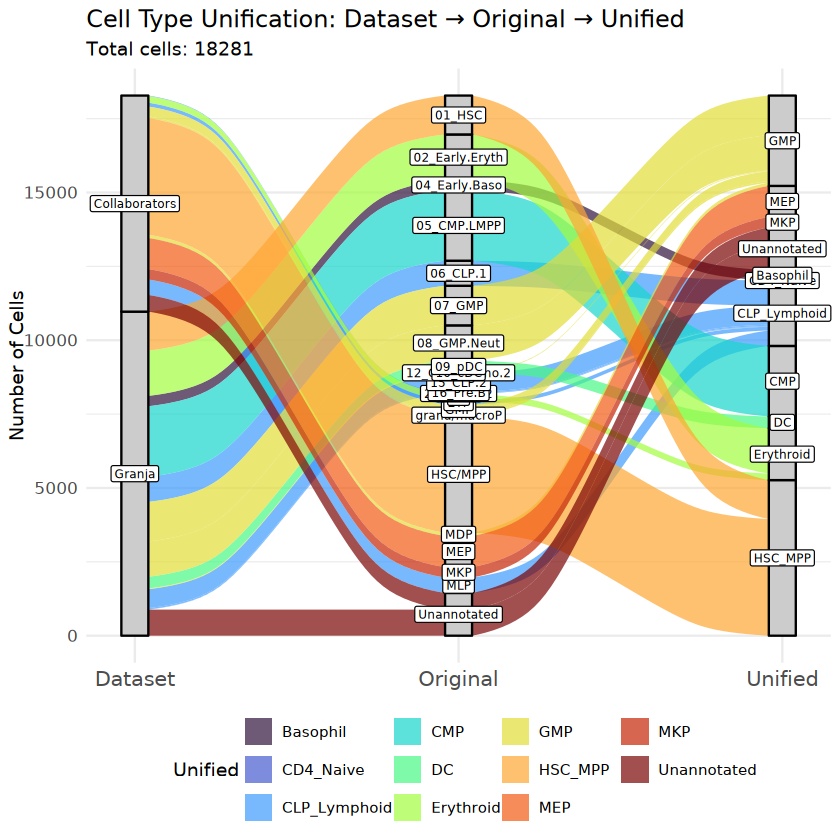

In [9]:
# Prepare data with three levels
raw_ct <- getCellColData(proj)$CellType
unified_ct <- getCellColData(proj)$CellType_Unified
sample <- getCellColData(proj)$Sample

# Create dataset labels
dataset <- ifelse(grepl("^collab_", sample), "Collaborators", "Granja")

alluvial_df <- data.frame(
  Dataset = dataset,
  Original = as.character(raw_ct),
  Unified = as.character(unified_ct)
) %>%
  mutate(
    Original = ifelse(is.na(Original), "Unannotated", Original),
    Unified = ifelse(is.na(Unified), "Unannotated", Unified)
  ) %>%
  group_by(Dataset, Original, Unified) %>%
  summarise(Freq = n(), .groups = "drop")

# Create three-level alluvial plot
p_alluvial_3level <- ggplot(alluvial_df,
                            aes(y = Freq, 
                                axis1 = Dataset, 
                                axis2 = Original, 
                                axis3 = Unified)) +
  geom_alluvium(aes(fill = Unified), width = 1/12, alpha = 0.7) +
  geom_stratum(width = 1/12, fill = "gray80", color = "black") +
  geom_label(stat = "stratum", aes(label = after_stat(stratum)), size = 2.5) +
  scale_x_discrete(limits = c("Dataset", "Original", "Unified"), 
                   expand = c(.05, .05)) +
  scale_fill_viridis_d(option = "turbo") +
  theme_minimal() +
  labs(title = "Cell Type Unification: Dataset → Original → Unified",
       subtitle = paste0("Total cells: ", sum(alluvial_df$Freq)),
       y = "Number of Cells") +
  theme(legend.position = "bottom",
        legend.title = element_text(face = "bold"),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 12, face = "bold"),
        plot.title = element_text(size = 14, face = "bold"))

print(p_alluvial_3level)

# Save plot
ggsave("CellType_Mapping_3Level_Alluvial.pdf", p_alluvial_3level, 
       width = 16, height = 12, device = "pdf")

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


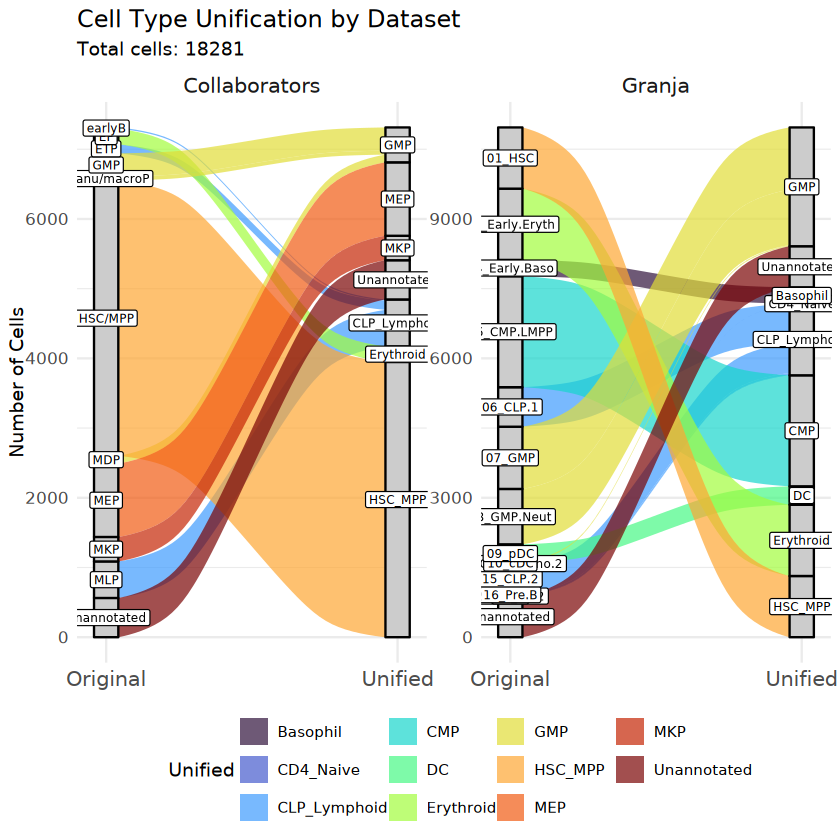

In [10]:
# Create separate plots for each dataset
p_alluvial_faceted <- ggplot(alluvial_df,
                              aes(y = Freq, 
                                  axis1 = Original, 
                                  axis2 = Unified)) +
  geom_alluvium(aes(fill = Unified), width = 1/12, alpha = 0.7) +
  geom_stratum(width = 1/12, fill = "gray80", color = "black") +
  geom_label(stat = "stratum", aes(label = after_stat(stratum)), size = 2.5) +
  scale_x_discrete(limits = c("Original", "Unified"), expand = c(.05, .05)) +
  scale_fill_viridis_d(option = "turbo") +
  facet_wrap(~Dataset, scales = "free_y") +
  theme_minimal() +
  labs(title = "Cell Type Unification by Dataset",
       subtitle = paste0("Total cells: ", sum(alluvial_df$Freq)),
       y = "Number of Cells") +
  theme(legend.position = "bottom",
        legend.title = element_text(face = "bold"),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 12, face = "bold"),
        plot.title = element_text(size = 14, face = "bold"),
        strip.text = element_text(size = 12, face = "bold"))

print(p_alluvial_faceted)

# Save
ggsave("CellType_Mapping_Faceted_Alluvial.pdf", p_alluvial_faceted, 
       width = 18, height = 10, device = "pdf")

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Cell Type Mapping: Original → Unified' in 'mbcsToSbcs': Punkt ersetzt <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Cell Type Mapping: Original → Unified' in 'mbcsToSbcs': Punkt ersetzt <86>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Cell Type Mapping: Original → Unified' in 'mbcsToSbcs': Punkt ersetzt <92>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Cell Type Mapping: Original → Unified' in 'mbcsToSbcs': Punkt ersetzt <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Cell Type Mapping: Original → Unified' in 'mbcsToSbcs': Punkt ersetzt <86>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$labe

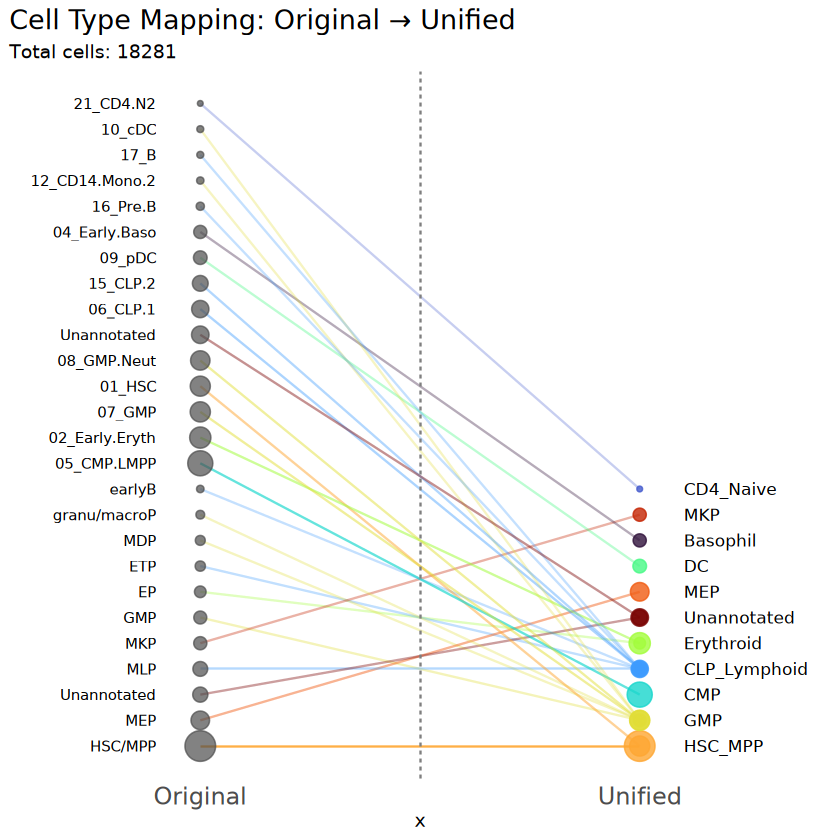

In [11]:
# Prepare data
raw_ct <- getCellColData(proj)$CellType
unified_ct <- getCellColData(proj)$CellType_Unified
sample <- getCellColData(proj)$Sample

dataset <- ifelse(grepl("^collab_", sample), "Collaborators", "Granja")

mapping_df <- data.frame(
  Dataset = dataset,
  Original = as.character(raw_ct),
  Unified = as.character(unified_ct)
) %>%
  mutate(
    Original = ifelse(is.na(Original), "Unannotated", Original),
    Unified = ifelse(is.na(Unified), "Unannotated", Unified)
  ) %>%
  group_by(Dataset, Original, Unified) %>%
  summarise(Freq = n(), .groups = "drop")

# Create positions for nodes
original_levels <- mapping_df %>% 
  group_by(Dataset, Original) %>% 
  summarise(Total = sum(Freq), .groups = "drop") %>%
  arrange(Dataset, desc(Total)) %>%
  mutate(y_pos = row_number())

unified_levels <- mapping_df %>% 
  group_by(Unified) %>% 
  summarise(Total = sum(Freq), .groups = "drop") %>%
  arrange(desc(Total)) %>%
  mutate(y_pos = row_number())

# Add positions to mapping data
mapping_plot <- mapping_df %>%
  left_join(original_levels %>% select(Dataset, Original, y_orig = y_pos), 
            by = c("Dataset", "Original")) %>%
  left_join(unified_levels %>% select(Unified, y_unif = y_pos), 
            by = "Unified")

# Simple line plot
p_lines <- ggplot(mapping_plot) +
  # Lines connecting original to unified
  geom_segment(aes(x = 1, xend = 3, 
                   y = y_orig, yend = y_unif,
                   color = Unified, 
                   alpha = Freq),
               linewidth = 0.5) +
  # Points for original cell types
  geom_point(aes(x = 1, y = y_orig, size = Freq), 
             color = "gray30", alpha = 0.7) +
  # Points for unified cell types
  geom_point(aes(x = 3, y = y_unif, size = Freq, color = Unified), 
             alpha = 0.8) +
  # Labels for original
  geom_text(data = original_levels, 
            aes(x = 0.8, y = y_pos, label = Original),
            hjust = 1, size = 3) +
  # Labels for unified
  geom_text(data = unified_levels,
            aes(x = 3.2, y = y_pos, label = Unified),
            hjust = 0, size = 3.5, fontface = "bold") +
  # Dataset separators
  geom_vline(xintercept = 2, linetype = "dashed", color = "gray50") +
  scale_color_viridis_d(option = "turbo") +
  scale_size_continuous(range = c(1, 8)) +
  scale_alpha_continuous(range = c(0.3, 0.9)) +
  scale_x_continuous(limits = c(0.3, 3.7), 
                     breaks = c(1, 3),
                     labels = c("Original", "Unified")) +
  theme_minimal() +
  labs(title = "Cell Type Mapping: Original → Unified",
       subtitle = paste0("Total cells: ", sum(mapping_df$Freq)),
       y = NULL) +
  theme(legend.position = "none",
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid = element_blank(),
        axis.text.x = element_text(size = 14, face = "bold"),
        plot.title = element_text(size = 16, face = "bold"))

print(p_lines)
ggsave("CellType_Mapping_Lines.pdf", p_lines, 
       width = 14, height = 12, device = "pdf")

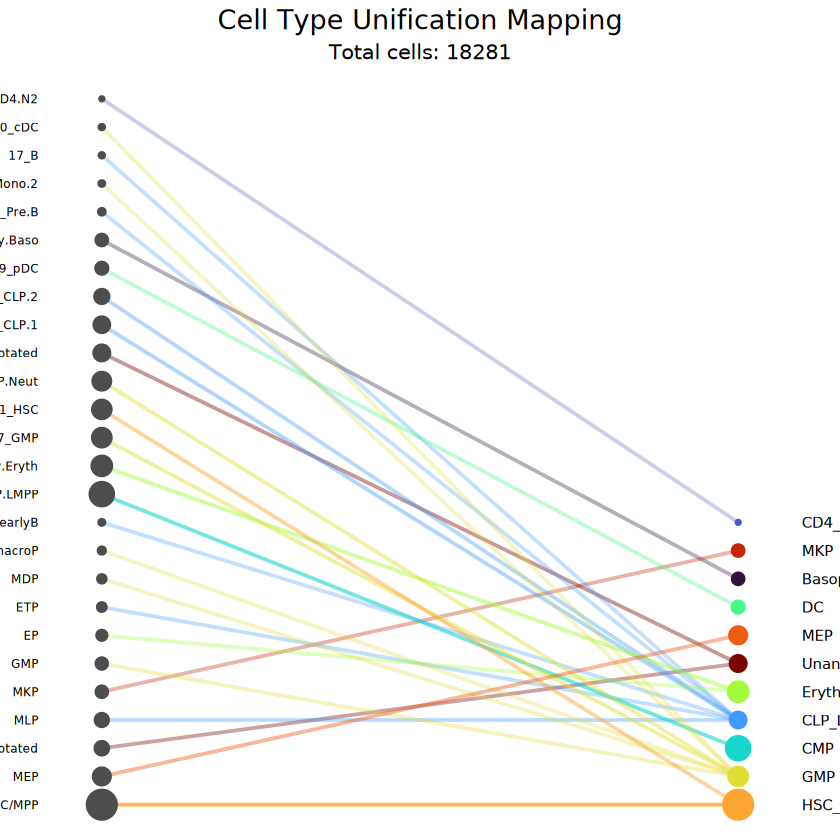

In [12]:
# Create arc diagram
p_arc <- ggplot(mapping_plot) +
  geom_link(aes(x = 1, xend = 3, 
                y = y_orig, yend = y_unif,
                color = Unified,
                alpha = Freq),
            linewidth = 0.8) +
  geom_point(aes(x = 1, y = y_orig, size = Freq), 
             color = "gray30") +
  geom_point(aes(x = 3, y = y_unif, size = Freq, color = Unified)) +
  geom_text(data = original_levels, 
            aes(x = 0.8, y = y_pos, label = Original),
            hjust = 1, size = 2.5) +
  geom_text(data = unified_levels,
            aes(x = 3.2, y = y_pos, label = Unified),
            hjust = 0, size = 3, fontface = "bold") +
  scale_color_viridis_d(option = "turbo") +
  scale_size_continuous(range = c(1, 8)) +
  scale_alpha_continuous(range = c(0.3, 0.8)) +
  theme_void() +
  labs(title = "Cell Type Unification Mapping",
       subtitle = paste0("Total cells: ", sum(mapping_df$Freq))) +
  theme(legend.position = "none",
        plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
        plot.subtitle = element_text(size = 12, hjust = 0.5))

print(p_arc)
ggsave("CellType_Mapping_Arc.pdf", p_arc, 
       width = 14, height = 12, device = "pdf")


Attache Paket: ‘tidyr’


Die folgenden Objekte sind maskiert von ‘package:Matrix’:

    expand, pack, unpack


Das folgende Objekt ist maskiert ‘package:S4Vectors’:

    expand


Das folgende Objekt ist maskiert ‘package:magrittr’:

    extract




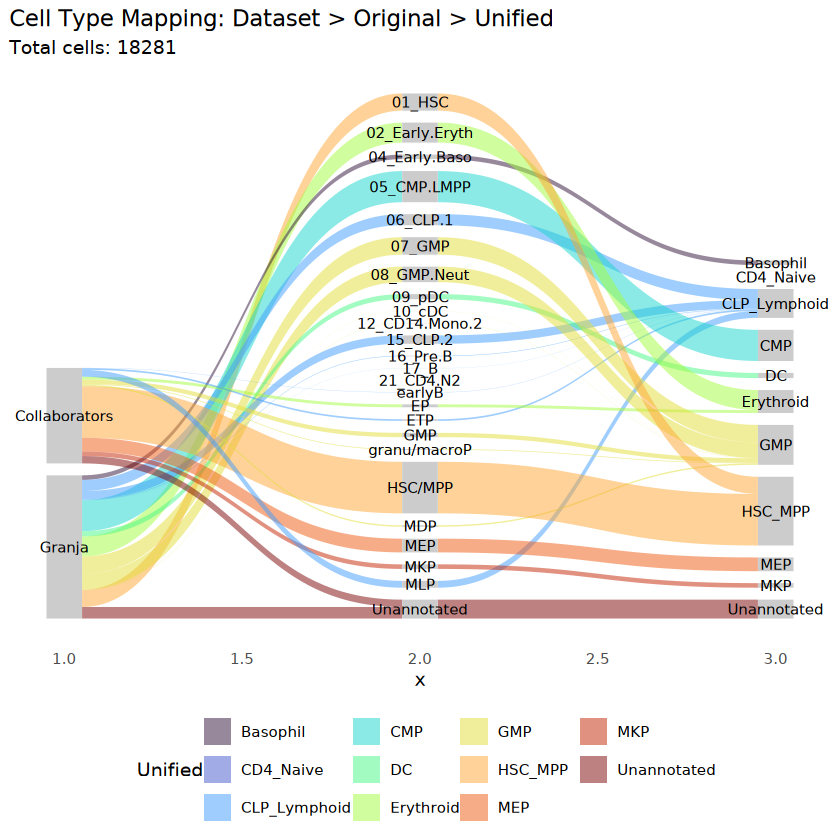

In [13]:
# Prepare data
raw_ct <- getCellColData(proj)$CellType
unified_ct <- getCellColData(proj)$CellType_Unified
sample <- getCellColData(proj)$Sample

dataset <- ifelse(grepl("^collab_", sample), "Collaborators", "Granja")

parallel_df <- data.frame(
  Dataset = dataset,
  Original = as.character(raw_ct),
  Unified = as.character(unified_ct)
) %>%
  mutate(
    Original = ifelse(is.na(Original), "Unannotated", Original),
    Unified = ifelse(is.na(Unified), "Unannotated", Unified)
  ) %>%
  group_by(Dataset, Original, Unified) %>%
  summarise(Freq = n(), .groups = "drop")

# Gather into long format for parallel coordinates
library(tidyr)
parallel_long <- parallel_df %>%
  gather_set_data(1:3)

p_parallel <- ggplot(parallel_long, aes(x = x, id = id, split = y, value = Freq)) +
  geom_parallel_sets(aes(fill = Unified), alpha = 0.5, axis.width = 0.1) +
  geom_parallel_sets_axes(axis.width = 0.1, fill = "gray80") +
  geom_parallel_sets_labels(angle = 0, size = 3) +
  scale_fill_viridis_d(option = "turbo") +
  theme_minimal() +
  labs(title = "Cell Type Mapping: Dataset > Original > Unified",  # Changed arrows
       subtitle = paste0("Total cells: ", sum(parallel_df$Freq))) +
  theme(legend.position = "bottom",
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank())

print(p_parallel)
ggsave("CellType_Mapping_Parallel.pdf", p_parallel, 
       width = 14, height = 10, device = "pdf")

In [14]:
# Create a mapping table with unified counts
mapping_table <- data.frame(
  Original = as.character(raw_ct),
  Unified = as.character(unified_ct)
) %>%
  mutate(
    Original = ifelse(is.na(Original), "Unannotated", Original),
    Unified = ifelse(is.na(Unified), "Unannotated", Unified)
  ) %>%
  group_by(Unified, Original) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Unified) %>%
  mutate(Unified_Total = sum(Count)) %>%
  ungroup() %>%
  arrange(desc(Unified_Total), Unified, desc(Count))

library(knitr)
kable(mapping_table, caption = "Cell Type Mapping Summary")

write.csv(mapping_table, "CellType_Mapping_Summary.csv", row.names = FALSE)

# Also create a summary of just unified cell types
unified_summary <- mapping_table %>%
  group_by(Unified) %>%
  summarise(
    Total_Cells = sum(Count),
    Num_Original_Types = n()
  ) %>%
  arrange(desc(Total_Cells))

kable(unified_summary, caption = "Unified Cell Type Summary")
write.csv(unified_summary, "Unified_CellType_Summary.csv", row.names = FALSE)



Table: Cell Type Mapping Summary

|Unified      |Original       | Count| Unified_Total|
|:------------|:--------------|-----:|-------------:|
|HSC_MPP      |HSC/MPP        |  3949|          5266|
|HSC_MPP      |01_HSC         |  1317|          5266|
|GMP          |07_GMP         |  1339|          3057|
|GMP          |08_GMP.Neut    |  1192|          3057|
|GMP          |GMP            |   333|          3057|
|GMP          |MDP            |   111|          3057|
|GMP          |granu/macroP   |    57|          3057|
|GMP          |12_CD14.Mono.2 |    16|          3057|
|GMP          |10_cDC         |     9|          3057|
|CMP          |05_CMP.LMPP    |  2388|          2388|
|CLP_Lymphoid |06_CLP.1       |   850|          2214|
|CLP_Lymphoid |15_CLP.2       |   642|          2214|
|CLP_Lymphoid |MLP            |   524|          2214|
|CLP_Lymphoid |ETP            |   130|          2214|
|CLP_Lymphoid |16_Pre.B       |    39|          2214|
|CLP_Lymphoid |earlyB         |    19|        



Table: Unified Cell Type Summary

|Unified      | Total_Cells| Num_Original_Types|
|:------------|-----------:|------------------:|
|HSC_MPP      |        5266|                  2|
|GMP          |        3057|                  7|
|CMP          |        2388|                  1|
|CLP_Lymphoid |        2214|                  7|
|Erythroid    |        1756|                  2|
|Unannotated  |        1447|                  1|
|MEP          |        1053|                  1|
|DC           |         397|                  1|
|Basophil     |         351|                  1|
|MKP          |         351|                  1|
|CD4_Naive    |           1|                  1|

In [15]:
unified_counts <- table(unified_ct, useNA = "always")
unified_sorted <- sort(unified_counts, decreasing = TRUE)

cat("\n=== Unified Cell Types sorted by count ===\n")
print(unified_sorted)


=== Unified Cell Types sorted by count ===
unified_ct
     HSC_MPP          GMP          CMP CLP_Lymphoid    Erythroid         <NA> 
        5266         3057         2388         2214         1756         1447 
         MEP           DC     Basophil          MKP    CD4_Naive 
        1053          397          351          351            1 


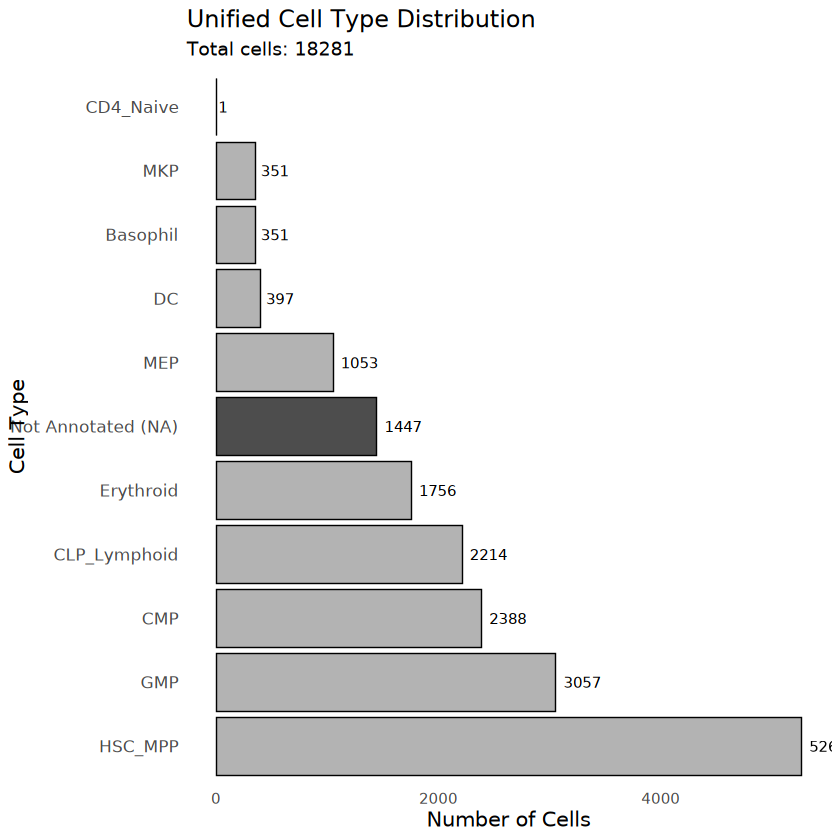

In [16]:
unified_df <- data.frame(
  CellType = as.character(unified_ct)
) %>%
  mutate(CellType = ifelse(is.na(CellType), "Not Annotated (NA)", CellType)) %>%
  group_by(CellType) %>%
  summarise(Count = n()) %>%
  arrange(desc(Count)) %>%
  mutate(CellType = factor(CellType, levels = CellType))

# Add column to identify Not Annotated
unified_df <- unified_df %>%
  mutate(IsUnannotated = CellType == "Not Annotated (NA)")

p_barplot_horiz_alt <- ggplot(unified_df, aes(x = CellType, y = Count)) +
  geom_bar(stat = "identity", 
           aes(fill = IsUnannotated),
           color = "black", linewidth = 0.3) +
  geom_text(aes(label = Count), hjust = -0.2, size = 3) +
  coord_flip() +
  scale_fill_manual(values = c("FALSE" = "grey70", "TRUE" = "grey30")) +
  theme_minimal() +
  labs(title = "Unified Cell Type Distribution",
       subtitle = paste0("Total cells: ", sum(unified_df$Count)),
       y = "Number of Cells",
       x = "Cell Type") +
  theme(plot.title = element_text(size = 14, face = "bold"),
        axis.title = element_text(size = 12, face = "bold"),
        axis.text.y = element_text(size = 10),
        panel.grid = element_blank(),
        legend.position = "none")

print(p_barplot_horiz_alt)

# Save
ggsave("Unified_CellType_Barplot_Horizontal.pdf", p_barplot_horiz_alt, 
       width = 10, height = 8, device = "pdf")

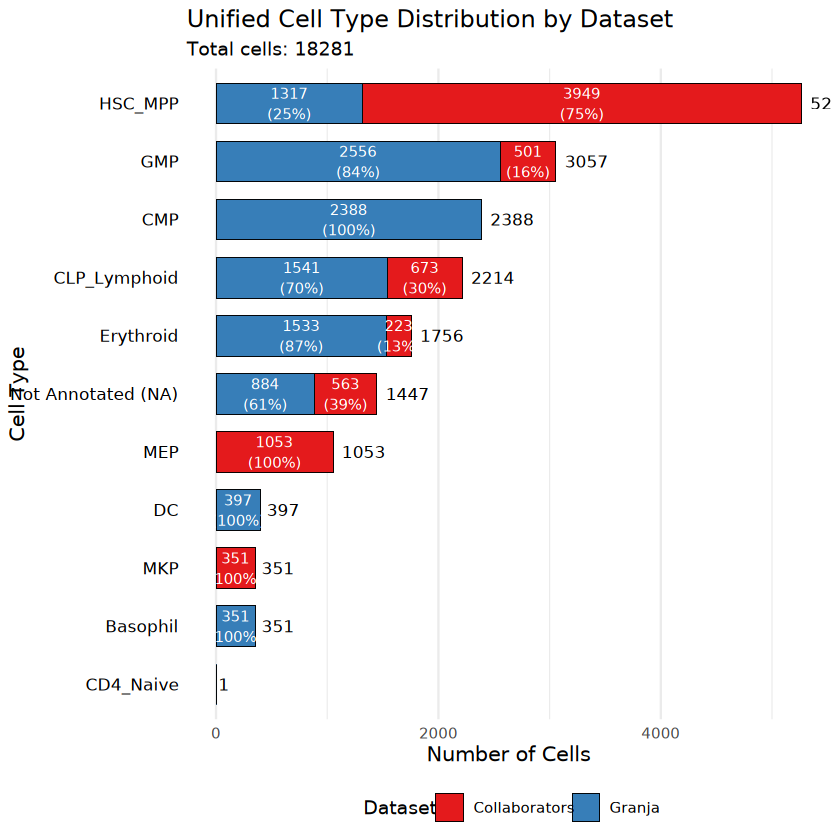

In [19]:
library(dplyr)
library(ggplot2)
library(scales)

# 1. Prepare Data
raw_ct <- getCellColData(proj)$CellType
unified_ct <- getCellColData(proj)$CellType_Unified
sample <- getCellColData(proj)$Sample

dataset <- ifelse(grepl("^collab_", sample), "Collaborators", "Granja")

split_df <- data.frame(
  CellType = as.character(unified_ct),
  Dataset = dataset
) %>%
  mutate(CellType = ifelse(is.na(CellType), "Not Annotated (NA)", CellType)) %>%
  group_by(CellType, Dataset) %>%
  summarise(Count = n(), .groups = "drop_last") %>%
  mutate(
    Total_Cluster_Size = sum(Count),
    Percentage = Count / Total_Cluster_Size
  ) %>%
  ungroup() %>%
  mutate(CellType = reorder(CellType, Total_Cluster_Size))

# Create a separate dataframe for the total labels to ensure no duplication
totals_df <- split_df %>% 
  select(CellType, Total_Cluster_Size) %>% 
  distinct()

# 2. Plot
p_split_bar <- ggplot(split_df, aes(x = CellType, y = Count, fill = Dataset)) +
  geom_bar(stat = "identity", position = "stack", width = 0.7, color = "black", linewidth = 0.2) +
  coord_flip() +
  
  geom_text(aes(label = ifelse(Count > 50, 
                               paste0(Count, "\n(", percent(Percentage, accuracy = 1), ")"), 
                               "")), 
            position = position_stack(vjust = 0.5), 
            size = 3, 
            color = "white", 
            fontface = "bold") +
  
  geom_text(data = totals_df,
            aes(x = CellType, y = Total_Cluster_Size, label = Total_Cluster_Size),
            inherit.aes = FALSE,
            hjust = -0.2,
            size = 3.5, 
            fontface = "italic") +

  scale_fill_manual(values = c("Granja" = "#377EB8", "Collaborators" = "#E41A1C")) +
  theme_minimal() +
  labs(title = "Unified Cell Type Distribution by Dataset",
       subtitle = paste0("Total cells: ", sum(split_df$Count)),
       y = "Number of Cells",
       x = "Cell Type") +
  theme(plot.title = element_text(size = 14, face = "bold"),
        axis.title = element_text(size = 12, face = "bold"),
        axis.text.y = element_text(size = 10, color = "black"),
        panel.grid.major.y = element_blank(),
        legend.position = "bottom")

print(p_split_bar)

ggsave("Unified_CellType_By_Dataset.pdf", p_split_bar, 
       width = 12, height = 8, device = "pdf")

In [17]:
saveArchRProject(proj, outputDirectory = "ArchR_Collab_vs_Pub_Annotated", load = FALSE)

Copying ArchRProject to new outputDirectory : /work/project/ladcol_013/bt-atac/notebooks/1_processing/test/ArchR_Collab_vs_Pub_Annotated

Copying Arrow Files...

Copying Arrow Files (1 of 5)

Copying Arrow Files (2 of 5)

Copying Arrow Files (3 of 5)

Copying Arrow Files (4 of 5)

Copying Arrow Files (5 of 5)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 6): collab_0

Copying Other Files (2 of 6): collab_1

Copying Other Files (3 of 6): granja_D7T1

Copying Other Files (4 of 6): granja_D8T1

Copying Other Files (5 of 6): granja_D9T1

Copying Other Files (6 of 6): Plots

Saving ArchRProject...

